In [2]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results

In [3]:
def func_u0(x):
    u0 = -1 *(0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x)))
    return u0

kappa = 0.001
alpha = 2.5

u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

  0%|          | 0/10099 [00:00<?, ?it/s]

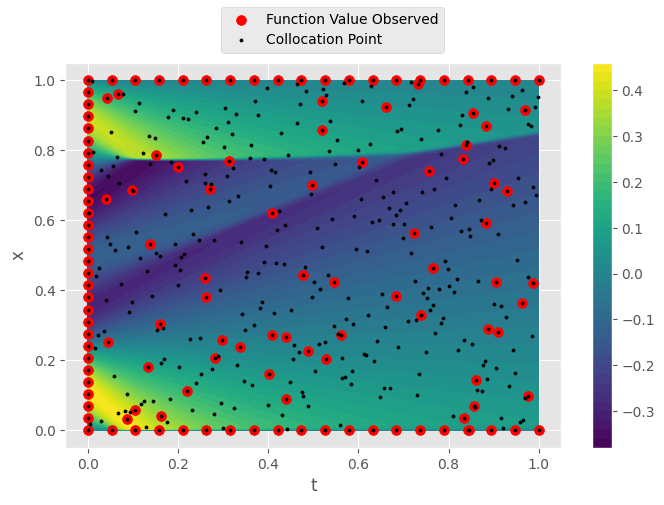

In [4]:
from data_utils import sample_xy_grid_latin


num_points = 60
sampled_points = jax.random.uniform(jax.random.PRNGKey(1048),(num_points,2))


interior,latin_boundary = sample_xy_grid_latin(300,jnp.array([0.,1]),jnp.array([0.,1]),20,30,100)
tx_bdy = latin_boundary[jnp.isin(latin_boundary[:,1],jnp.array([0.,1.]))]
tx_int = jnp.vstack(
    [interior,latin_boundary[
        ~jnp.isin(latin_boundary[:,1],jnp.array([0.,1]))
                  ]]
)

tx_int = tx_int[tx_int[:,0]<1]
tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy,
    num_obs_to_sample=0,
    prng_key=jax.random.PRNGKey(55),
    tx_obs_to_include=sampled_points,
    times_to_observe = (0,),
)

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)

In [32]:
import Kernels
reload(Kernels)
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import log1pexp,inv_log1pexp

def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,5 * jnp.ones(2),stepsize = 1e-5,maxiter = 10000)
ML_lengthscales = log1pexp(fitted_params)

k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))
print(1/(jnp.sqrt(ML_lengthscales)))


u_model = CholInducedRKHS(
    tx_all,
    (eval_k,),#feature_operators,# (eval_k,)
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)

[0.16516686 0.08327989]


In [33]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])


In [34]:
params_init.shape

(756,)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.375, Jres = 27.08, alpha = 0.08333, improvement_ratio = 0.975
Iteration 1, loss = 0.1934, Jres = 13.08, alpha = 0.06944, improvement_ratio = 0.9756
Iteration 2, loss = 0.133, Jres = 1.677, alpha = 0.05787, improvement_ratio = 1.013
Iteration 3, loss = 0.1052, Jres = 0.7923, alpha = 0.04823, improvement_ratio = 1.023
Iteration 4, loss = 0.08903, Jres = 0.3949, alpha = 0.04019, improvement_ratio = 1.026
Iteration 5, loss = 0.07813, Jres = 0.5129, alpha = 0.03349, improvement_ratio = 1.021
Iteration 100, loss = 0.004954, Jres = 0.008137, alpha = 8.333e-07, improvement_ratio = 1.017
Iteration 200, loss = 0.002514, Jres = 0.02826, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 300, loss = 0.001618, Jres = 0.0214, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.001295, Jres = 0.05352, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 500, loss = 0.00113, Jres = 0.05966, alpha = 8.333e-07, improvement_ratio = 0.9997


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 0.0011245523014623156
Iteration 100, loss = 0.0005618152640960519
Iteration 200, loss = 0.00035499398513477633
Iteration 300, loss = 0.0002594808782291524
Iteration 400, loss = 0.00019061447658559637
Iteration 500, loss = 0.0001776797206222476
Converged


/tmp/ipykernel_3914845/827981398.py:30: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


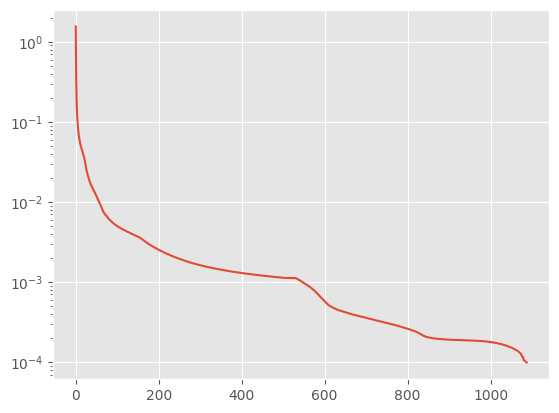

In [29]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)

p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,1e-2,1000,overall_regularization=1e-13,tol = 1e-14,print_every = 100)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

In [31]:
EqnModel.jac(params).shape

(456, 1612)

Pre Refinement PDE MSE 0.001030639971073373
Post Refinement PDE MSE 0.00012916109577234205


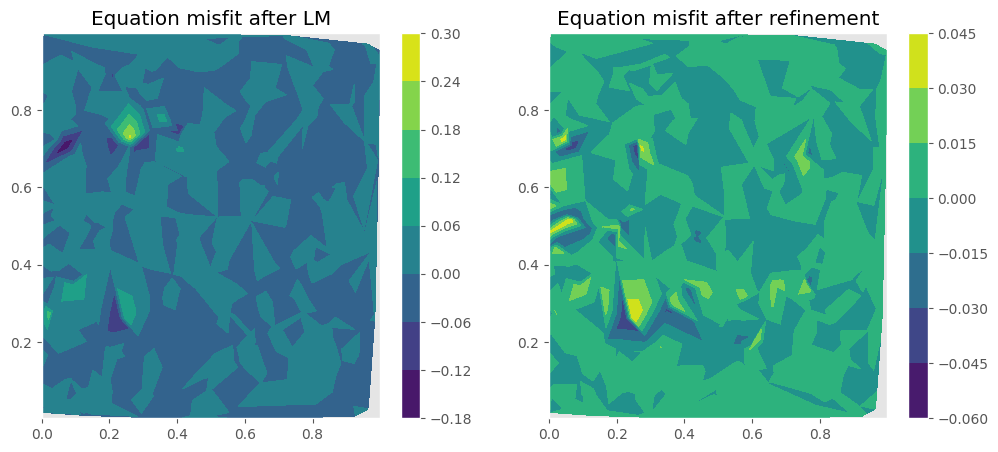

In [27]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.tricontourf(tx_int[:,0],tx_int[:,1],equation_residuals)
plt.grid(None)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Equation misfit after refinement")
plt.tricontourf(tx_int[:,0],tx_int[:,1],equation_residuals_refined)
plt.grid(None)
plt.colorbar()
plt.show()


,NRMSE,NMAE
1 Step,0.507594,0.382066
2 Step,1.220165,0.906336


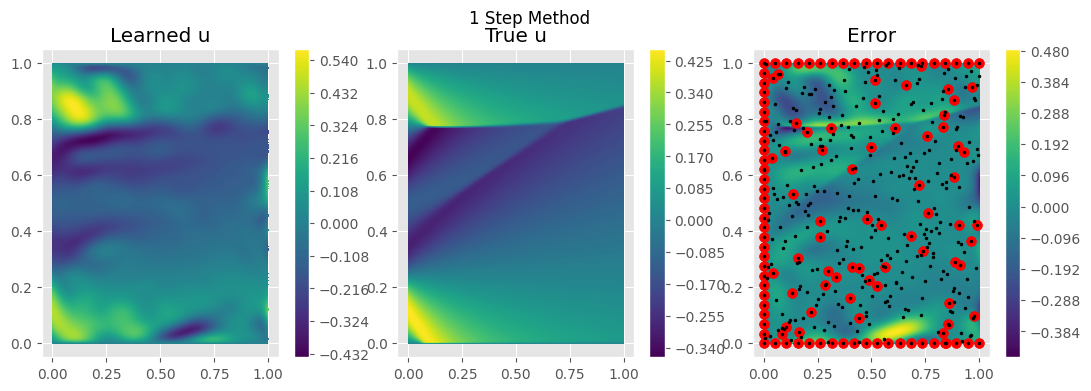

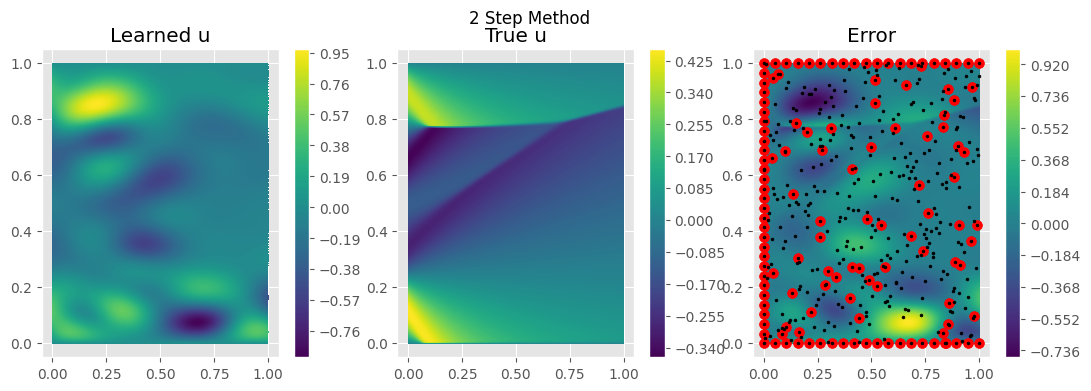

In [28]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)